In [1]:
%load_ext memory_profiler

In [2]:
base_grid_kwargs = {
    "size_x": 1080, 
    "size_y": 1080, 
    "center_lon": -20, 
    "center_lat": 65, 
    "rot": 0, 
    "topography_source": {
        "name": "SRTM15",
        "path": "/global/cfs/projectdirs/m4746/Datasets/SRTM15/SRTM15_V2.6.nc",
    }
}

In [3]:
grids = {
    "A": {"nx": 1080, "ny": 1080, "N": 100, **base_grid_kwargs},
    "B": {"nx": 2000, "ny": 2000, "N": 100, **base_grid_kwargs},  
    "C": {"nx": 2000, "ny": 2000, "N": 500, **base_grid_kwargs},   
}

# Performance

In [4]:
key = "A"

In [5]:
use_dask = True
bypass_validation = True

In [6]:
from roms_tools import Grid

We first create our grid object.

In [7]:
grid = Grid(**grids[key])

Given our grid, our goal is now to create the necessary tidal forcing fields to run a ROMS simulation.

The tidal forcing is based on the TPXO atlas, which sits on perlmutter at the following location.

In [8]:
path = "/global/cfs/projectdirs/m4746/Datasets/TPXO/tpxo9.v2a.nc"

You can also download your own version. For more details, please refer to [this page](https://roms-tools.readthedocs.io/en/latest/datasets.html).

We now create our tidal forcing for a model reference date of January 1st, 2000.

In [9]:
from roms_tools import TidalForcing

In [10]:
from datetime import datetime

In [11]:
model_reference_date = datetime(2000, 1, 1)

In [12]:
%%time
%%memit

tidal_forcing = TidalForcing(
    grid=grid,
    source={"name": "TPXO", "path": path},
    ntides=10,  # number of constituents to consider <= 14. Default is 10.
    allan_factor=2.0,  # Allan factor. Default is 2.0.
    model_reference_date=model_reference_date,  # Model reference date. Default is January 1, 2000.
    use_dask=use_dask,
    bypass_validation=bypass_validation
)

peak memory: 591.32 MiB, increment: 53.12 MiB
CPU times: user 21.3 s, sys: 139 ms, total: 21.4 s
Wall time: 3.11 s


In [13]:
tidal_forcing.ds

<xarray.Dataset> Size: 374MB
Dimensions:  (ntides: 10, eta_rho: 1082, xi_rho: 1082, xi_u: 1081, eta_v: 1081)
Coordinates:
    omega    (ntides) float64 80B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: ntides, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    ssh_Re   (ntides, eta_rho, xi_rho) float32 47MB dask.array<chunksize=(1, 1082, 1082), meta=np.ndarray>
    ssh_Im   (ntides, eta_rho, xi_rho) float32 47MB dask.array<chunksize=(1, 1082, 1082), meta=np.ndarray>
    pot_Re   (ntides, eta_rho, xi_rho) float32 47MB dask.array<chunksize=(1, 1082, 1082), meta=np.ndarray>
    pot_Im   (ntides, eta_rho, xi_rho) float32 47MB dask.array<chunksize=(1, 1082, 1082), meta=np.ndarray>
    u_Re     (ntides, eta_rho, xi_u) float32 47MB dask.array<chunksize=(1, 1082, 1081), meta=np.ndarray>
    v_Re     (ntides, eta_v, xi_rho) float32 47MB dask.array<chunksize=(1, 1081, 1082), meta=np.ndarray>
    u_Im     (ntides, eta_rho, xi_u) float32 47MB dask.array<chunksize=(1, 1082, 1081), meta=np.ndarray>
    v_Im     (ntides, eta_v, xi_rho) float32 47MB dask.array<chunksize=(1, 1081, 1082), meta=np.ndarray>
Attributes:
    title:                 ROMS tidal forcing created by ROMS-Tools
    roms_tools_version:    0.1.dev177
    source:                TPXO
    model_reference_date:  2000-01-01 00:00:00
    allan_factor:          2.0

In [14]:
print(f"Memory footprint: {tidal_forcing.ds.nbytes / 1e6:.2f} MB")


Memory footprint: 374.46 MB


To see the values of the tidal forcing variables we can examine the `xarray.Dataset` object returned by the `.ds` property.

We can also plot any of the tidal forcing fields via the `.plot` method.

[########################################] | 100% Completed | 404.34 ms
peak memory: 743.27 MiB, increment: 151.70 MiB
CPU times: user 16 s, sys: 229 ms, total: 16.3 s
Wall time: 1.42 s


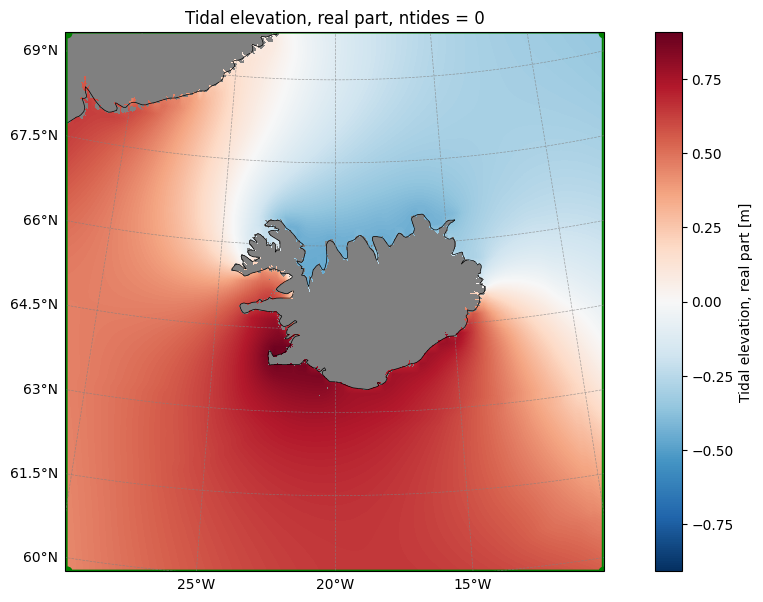

In [15]:
%%time
%%memit

tidal_forcing.plot("ssh_Re", ntides=0)

## Saving as NetCDF or YAML file

Finally, we can save our tidal forcing as a netCDF file via the `.save` method.

In [16]:
filepath = "/pscratch/sd/n/nloose/forcing/my_tidal_forcing.nc"

In [19]:
%%time
%%memit

tidal_forcing.save(filepath)

peak memory: 11395.59 MiB, increment: 5385.36 MiB
CPU times: user 7min 53s, sys: 35.9 s, total: 8min 29s
Wall time: 10.2 s


We can also export the parameters of our `TidalForcing` object to a YAML file.

In [18]:
filepath = "/pscratch/sd/n/nloose/forcing/my_tidal_forcing2.nc"

In [20]:
import xarray as xr

In [21]:
ds1 = xr.open_dataset("/pscratch/sd/n/nloose/forcing/my_tidal_forcing.nc")
ds2 = xr.open_dataset("/pscratch/sd/n/nloose/forcing/my_tidal_forcing2.nc")

In [22]:
ds1

<xarray.Dataset> Size: 374MB
Dimensions:  (ntides: 10, eta_rho: 1082, xi_rho: 1082, xi_u: 1081, eta_v: 1081)
Coordinates:
    omega    (ntides) float64 80B ...
Dimensions without coordinates: ntides, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    ssh_Re   (ntides, eta_rho, xi_rho) float32 47MB ...
    ssh_Im   (ntides, eta_rho, xi_rho) float32 47MB ...
    pot_Re   (ntides, eta_rho, xi_rho) float32 47MB ...
    pot_Im   (ntides, eta_rho, xi_rho) float32 47MB ...
    u_Re     (ntides, eta_rho, xi_u) float32 47MB ...
    v_Re     (ntides, eta_v, xi_rho) float32 47MB ...
    u_Im     (ntides, eta_rho, xi_u) float32 47MB ...
    v_Im     (ntides, eta_v, xi_rho) float32 47MB ...
Attributes:
    title:                 ROMS tidal forcing created by ROMS-Tools
    roms_tools_version:    0.1.dev177
    source:                TPXO
    model_reference_date:  2000-01-01 00:00:00
    allan_factor:          2.0

In [23]:
ds2

<xarray.Dataset> Size: 374MB
Dimensions:  (ntides: 10, eta_rho: 1082, xi_rho: 1082, xi_u: 1081, eta_v: 1081)
Coordinates:
    omega    (ntides) float64 80B ...
Dimensions without coordinates: ntides, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    ssh_Re   (ntides, eta_rho, xi_rho) float32 47MB ...
    ssh_Im   (ntides, eta_rho, xi_rho) float32 47MB ...
    pot_Re   (ntides, eta_rho, xi_rho) float32 47MB ...
    pot_Im   (ntides, eta_rho, xi_rho) float32 47MB ...
    u_Re     (ntides, eta_rho, xi_u) float32 47MB ...
    v_Re     (ntides, eta_v, xi_rho) float32 47MB ...
    u_Im     (ntides, eta_rho, xi_u) float32 47MB ...
    v_Im     (ntides, eta_v, xi_rho) float32 47MB ...
Attributes:
    title:                 ROMS tidal forcing created by ROMS-Tools
    roms_tools_version:    0.1.dev177
    source:                TPXO
    model_reference_date:  2000-01-01 00:00:00
    allan_factor:          2.0

In [24]:
ds1.equals(ds2)

True